# Forecasting

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10,7
import matplotlib.dates as mdates
import time
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 6)})
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
df = pd.read_csv('Data/train.csv')
print(df.shape)

df['Date'] = pd.to_datetime(df['Index'], format='%d/%m/%Y %H:%M')

df = df[['Date','Load']]
df = df.set_index('Date')
df.Load.fillna(df.Load.mean(), inplace=True) 
df.head(3)

(8064, 2)


,Load
Date,
2013-01-01 00:00:00,714.6
2013-01-01 00:15:00,784.7
2013-01-01 00:30:00,644.0


In [3]:
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.day_name()

In [4]:
df.tail()

,Load,Year,Month,Weekday Name
Date,,,,
2013-03-25 22:45:00,1090.3,2013,3,Monday
2013-03-25 23:00:00,1079.0,2013,3,Monday
2013-03-25 23:15:00,1096.7,2013,3,Monday
2013-03-25 23:30:00,810.6,2013,3,Monday
2013-03-25 23:45:00,926.5,2013,3,Monday


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Train/Test data split

Classical ML train/test split is not suitable for time series forecasting. In case of time series data is split based on time stamp. For example for a 1 year data , the split would be 9-train/2-val/1-test ratio. 

In [6]:
#In this case I used 2 months for trainig, arounf 3 weeks for validation & 1 week for testing.

train_df = df['2013-01-01 00:00:00':'2013-02-28 23:45:00']
val_df   = df['2013-03-01 00:00:00':'2013-03-17 23:45:00']
test_df  = df['2013-03-18 00:00:00':'2013-03-24 23:45:00']

### Plot

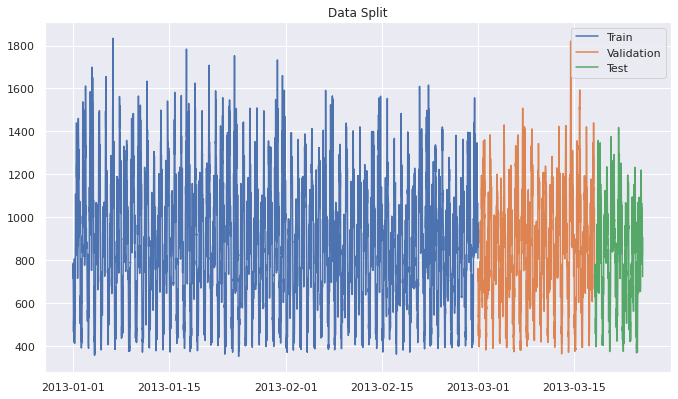

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df.Load, label='Train')
plt.plot(val_df.index, val_df.Load, label='Validation')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.legend(loc='best')
plt.title("Data Split")
plt.show()

## Average Forecast
The average model assumes that the best predictor of what will happen tomorrow, is the average of everything
that has happened up until now.


In [8]:
naive_forecast_val = train_df['Load'].mean()
series = train_df.Load.to_list() + val_df.Load.to_list()
test_df['average'] = np.mean(np.array(series))
np.mean(series)

870.1026752614249

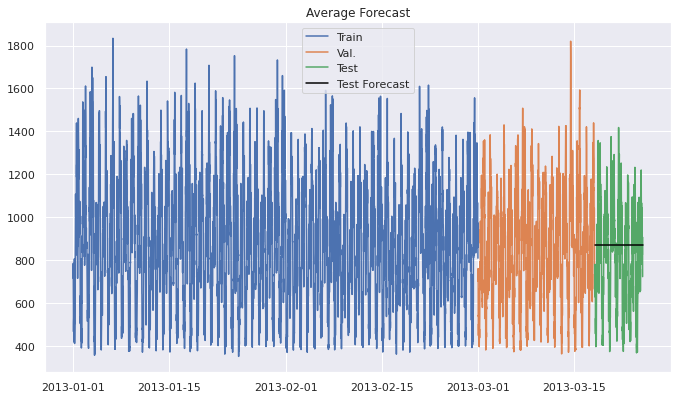

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df.Load, label='Train')
#plt.plot(train_df.index, naive_forecast_train, label='Train Forecast')
plt.plot(val_df.index, val_df.Load, label='Val.')
#plt.plot(val_df.index, naive_forecast_val, label='Val. Forecast')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(test_df.index, test_df.average, label='Test Forecast',color="black")


plt.legend(loc='best')
plt.title("Average Forecast")
plt.show()

In [10]:
rms = sqrt(mean_squared_error(test_df.Load, test_df.average))
print(rms)

239.51047218655668


## Naive Forecast
In this method all forecasts are simply set to be the value of the last observation.

In [11]:
naive_forecast_train = train_df['Load'].shift(1)
naive_forecast_val = val_df['Load'].shift(1)
test_df['naive'] = val_df['Load'][-1]

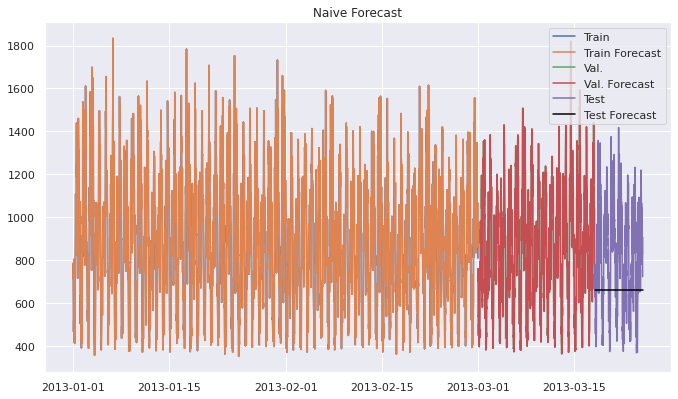

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df.Load, label='Train')
plt.plot(train_df.index, naive_forecast_train, label='Train Forecast')
plt.plot(val_df.index, val_df.Load, label='Val.')
plt.plot(val_df.index, naive_forecast_val, label='Val. Forecast')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(test_df.index, test_df.naive, label='Test Forecast',color="black")


plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

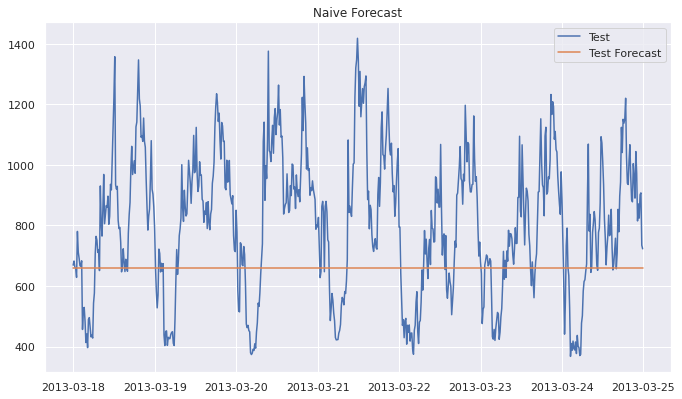

272.96179448780003


In [13]:
plt.figure(figsize=(10, 6))
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(test_df.index, test_df.naive, label='Test Forecast')


plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

rms = sqrt(mean_squared_error(test_df.Load, test_df.naive))
print(rms)

## Moving Average Forecast

This method uses the average of a time series over a defined number of time periods.
For example, if you want a two-year moving average for a data set from 2000, 2001, 2002 and 2003 you would find averages for the subsets 2000/2001, 2001/2002 and 2002/2003.
https://www.statisticshowto.datasciencecentral.com/moving-average/

I have used pandas rolling function for moving avg.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

In [14]:
temp_df = pd.DataFrame()
temp_df['Load'] = train_df.Load.to_list() + val_df.Load.to_list()
test_df['moving_avg'] = temp_df['Load'].rolling(60).mean().iloc[-1]

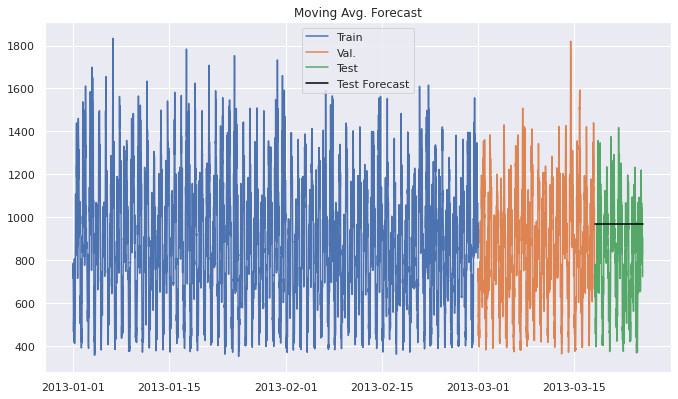

282.59226852158326


In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df.Load, label='Train')
#plt.plot(train_df.index, naive_forecast_train, label='Train Forecast')
plt.plot(val_df.index, val_df.Load, label='Val.')
#plt.plot(val_df.index, naive_forecast_val, label='Val. Forecast')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(test_df.index, test_df.moving_avg, label='Test Forecast',color="black")


plt.legend(loc='best')
plt.title("Moving Avg. Forecast")
plt.show()

rms = sqrt(mean_squared_error(test_df.Load, test_df.moving_avg))
print(rms)

## Exponential Smoothing

In [16]:
temp_df = pd.DataFrame()
temp_df['Load'] = train_df.Load.to_list() + val_df.Load.to_list()

fit2 = SimpleExpSmoothing(np.asarray(temp_df['Load'])).fit(smoothing_level=0.6,optimized=True)
test_df['exp_smoothing'] = fit2.forecast(len(test_df))

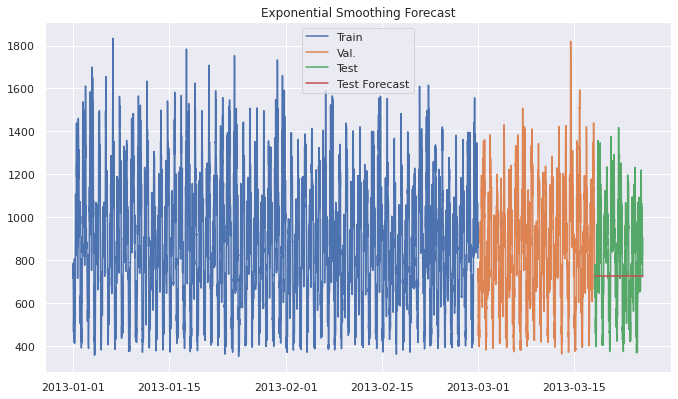

244.0988831023512


In [17]:
plt.figure(figsize=(10, 6))
plt.plot(train_df.index, train_df.Load, label='Train')
#plt.plot(train_df.index, naive_forecast_train, label='Train Forecast')
plt.plot(val_df.index, val_df.Load, label='Val.')
#plt.plot(val_df.index, naive_forecast_val, label='Val. Forecast')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(test_df.index, test_df.exp_smoothing, label='Test Forecast')


plt.legend(loc='best')
plt.title("Exponential Smoothing Forecast")
plt.show()
rms = sqrt(mean_squared_error(test_df.Load, test_df.exp_smoothing))
print(rms)

In [22]:
#val_df['Time'] = [datetime.time(d) for d in val_df.index] 
test_df['Time'] = [datetime.time(d) for d in test_df.index] 
test_df['DateTime'] = [d for d in test_df.index] 

In [23]:
train = df['2013-01-01 00:00:00':'2013-03-17 23:45:00']
train['DateTime'] = train.index 
train['Time'] = [datetime.time(d) for d in train.index] 

In [24]:
test_df

,Load,Year,Month,Weekday Name,average,naive,moving_avg,exp_smoothing,Time,DateTime
Date,,,,,,,,,,
2013-03-18 00:00:00,668.9,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:00:00,2013-03-18 00:00:00
2013-03-18 00:15:00,682.4,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:15:00,2013-03-18 00:15:00
2013-03-18 00:30:00,662.3,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:30:00,2013-03-18 00:30:00
2013-03-18 00:45:00,659.1,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:45:00,2013-03-18 00:45:00
2013-03-18 01:00:00,628.4,2013,3,Monday,870.102675,659.6,968.841667,725.673843,01:00:00,2013-03-18 01:00:00
...,...,...,...,...,...,...,...,...,...,...
2013-03-24 22:45:00,824.3,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,22:45:00,2013-03-24 22:45:00
2013-03-24 23:00:00,901.4,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,23:00:00,2013-03-24 23:00:00
2013-03-24 23:15:00,907.5,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,23:15:00,2013-03-24 23:15:00


In [25]:
temp = train.groupby(by=['Weekday Name','Time']).mean()
print(len(temp))
temp2 = temp.reset_index()
print(len(temp2))
temp2

672
672


,Weekday Name,Time,Load,Year,Month
0,Friday,00:00:00,803.381818,2013.0,1.909091
1,Friday,00:15:00,720.045455,2013.0,1.909091
2,Friday,00:30:00,680.354545,2013.0,1.909091
3,Friday,00:45:00,576.518182,2013.0,1.909091
4,Friday,01:00:00,520.218182,2013.0,1.909091
...,...,...,...,...,...
667,Wednesday,22:45:00,873.081818,2013.0,1.727273
668,Wednesday,23:00:00,938.009091,2013.0,1.727273
669,Wednesday,23:15:00,888.645455,2013.0,1.727273
670,Wednesday,23:30:00,862.754545,2013.0,1.727273


In [29]:
result = pd.merge(test_df, temp2, on=["Weekday Name", "Time"])
result = result.set_index('DateTime')
result

,Load_x,Year_x,Month_x,Weekday Name,average,naive,moving_avg,exp_smoothing,Time,Load_y,Year_y,Month_y
DateTime,,,,,,,,,,,,
2013-03-18 00:00:00,668.9,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:00:00,742.450000,2013.0,1.800000
2013-03-18 00:15:00,682.4,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:15:00,681.870000,2013.0,1.800000
2013-03-18 00:30:00,662.3,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:30:00,661.060000,2013.0,1.800000
2013-03-18 00:45:00,659.1,2013,3,Monday,870.102675,659.6,968.841667,725.673843,00:45:00,576.780000,2013.0,1.800000
2013-03-18 01:00:00,628.4,2013,3,Monday,870.102675,659.6,968.841667,725.673843,01:00:00,544.390000,2013.0,1.800000
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-24 22:45:00,824.3,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,22:45:00,1062.963636,2013.0,1.909091
2013-03-24 23:00:00,901.4,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,23:00:00,1112.954545,2013.0,1.909091
2013-03-24 23:15:00,907.5,2013,3,Sunday,870.102675,659.6,968.841667,725.673843,23:15:00,964.327273,2013.0,1.909091


In [30]:
result.Load_y.fillna(result.Load_y.mean())
len(test_df)


672

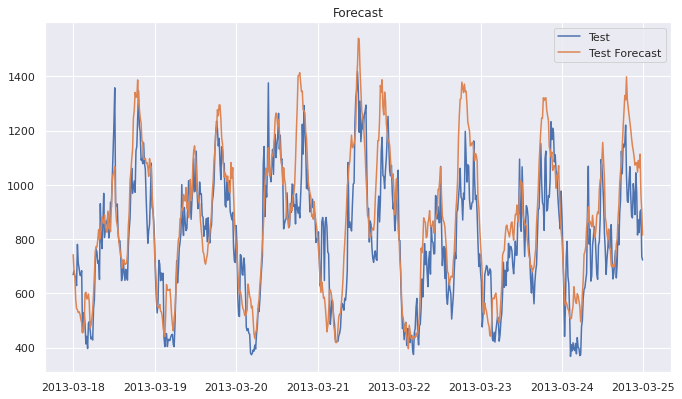

In [31]:
plt.figure(figsize=(10, 6))
# plt.plot(train.index, train.Load, label='Train')
# #plt.plot(train_df.index, naive_forecast_train, label='Train Forecast')
plt.plot(test_df.index, test_df.Load, label='Test')
plt.plot(result.index, result.Load_y, label='Test Forecast')


plt.legend(loc='best')
plt.title("Forecast")
plt.show()

Instead of using the all the previous data as one TS, I used
only the corresponding time and week day values for next week.
For example, to forecast the next week load for Monday 00:15:00, I use all the past Monday's 00:15:00 data for forecasting.

I think that's a pretty good baseline to work with and further improve the model to get better results.


In [33]:
df_result = pd.read_csv('Data/sample_submission.csv')
print(df_result.shape)

(672, 2)


In [34]:
df_result['Date'] = pd.to_datetime(df_result['Index'], format='%d/%m/%Y %H:%M')

df_result = df_result[['Date','Load']]
df_result = df_result.set_index('Date')
df_result.Load.fillna(df_result.Load.mean(), inplace=True) 

df_result['Year'] = df_result.index.year
df_result['Month'] = df_result.index.month
df_result['Weekday Name'] = df_result.index.day_name()
df_result['Time'] = [datetime.time(d) for d in df_result.index]
df_result['DateTime'] = [d for d in df_result.index] 
df_result.head()

,Load,Year,Month,Weekday Name,Time,DateTime
Date,,,,,,
2013-03-26 00:00:00,0,2013,3,Tuesday,00:00:00,2013-03-26 00:00:00
2013-03-26 00:15:00,0,2013,3,Tuesday,00:15:00,2013-03-26 00:15:00
2013-03-26 00:30:00,0,2013,3,Tuesday,00:30:00,2013-03-26 00:30:00
2013-03-26 00:45:00,0,2013,3,Tuesday,00:45:00,2013-03-26 00:45:00
2013-03-26 01:00:00,0,2013,3,Tuesday,01:00:00,2013-03-26 01:00:00


In [35]:
df['Time'] = [datetime.time(d) for d in df.index]
temp = df.groupby(by=['Weekday Name','Time']).mean()
temp2 = temp.reset_index()
temp2

,Weekday Name,Time,Load,Year,Month
0,Friday,00:00:00,802.625000,2013.0,2.000000
1,Friday,00:15:00,726.258333,2013.0,2.000000
2,Friday,00:30:00,677.200000,2013.0,2.000000
3,Friday,00:45:00,574.716667,2013.0,2.000000
4,Friday,01:00:00,516.025000,2013.0,2.000000
...,...,...,...,...,...
667,Wednesday,22:45:00,876.908333,2013.0,1.833333
668,Wednesday,23:00:00,935.075000,2013.0,1.833333
669,Wednesday,23:15:00,888.416667,2013.0,1.833333
670,Wednesday,23:30:00,856.475000,2013.0,1.833333


In [38]:
result = pd.merge(df_result, temp2, on=["Weekday Name", "Time"])
result = result.set_index('DateTime')
result = result[['Load_y']]
result.rename(columns = {'Load_y':'Load'}, inplace = True)
result.to_csv('Result/submission.csv')
result

,Load
DateTime,
2013-03-26 00:00:00,749.433333
2013-03-26 00:15:00,688.558333
2013-03-26 00:30:00,625.741667
2013-03-26 00:45:00,548.433333
2013-03-26 01:00:00,551.450000
...,...
2013-04-01 22:45:00,1056.375000
2013-04-01 23:00:00,1069.308333
2013-04-01 23:15:00,971.575000


In [ ]:
re

# Improvements

- Given the location, add temperature related features
- Add complete one year data to capture per year seasonality and trends
- Use ML models Like gradient boosting, NNs or LSTMs on the data